In [1]:
%matplotlib inline
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data
from SALib.sample import latin, saltelli, fast_sampler
from SALib.sample.morris import sample
from SALib.analyze import sobol, fast, morris
from functions.stylizedfacts import *
from functions.evolutionaryalgo import *
from functions.sensitivity_analysis import *
from functions.helpers import *
import simfinmodel
import init_objects
import matplotlib.pyplot as plt
from matplotlib import style
import quandl
import json
import scipy
import ast

C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
style.use('ggplot')

In [3]:
empirical_moments = np.array([ -9.56201354e-03,  -9.55051841e-02,  -5.52010512e-02,
         3.35217232e-01,   1.24673150e+01,   3.46352635e-01,
         2.72135459e-01,   1.88193342e-01,   1.75876698e-01,
        -3.39594806e+00])

W = np.array([[  3.19813864e+05,  -1.23647688e+04,  -7.75253249e+02,
         -9.96776357e+02,  -3.46059595e+01,  -8.45442951e+01,
          1.30642711e+02,   8.21228832e+02,  -7.53254275e+02,
          4.01244860e-01],
       [ -1.23647688e+04,   3.09643983e+03,  -9.12387428e+02,
          7.15088809e+02,   4.00622557e+00,  -2.07088870e+02,
          2.23333826e+02,   2.47454265e+01,  -7.69804083e+01,
         -9.32556575e-01],
       [ -7.75253249e+02,  -9.12387428e+02,   2.45450034e+03,
         -5.66285993e+02,   2.50019644e+00,   7.52973406e+01,
         -6.53708966e+01,   1.49542112e+01,  -3.22682344e+01,
         -8.15971301e-02],
       [ -9.96776357e+02,   7.15088809e+02,  -5.66285993e+02,
          6.03184170e+02,  -6.93622662e+00,  -3.92832732e+01,
          5.68213213e+01,  -2.51354209e+01,  -5.92040756e-01,
         -1.47482933e-01],
       [ -3.46059595e+01,   4.00622557e+00,   2.50019644e+00,
         -6.93622662e+00,   2.12483995e-01,  -1.07699983e+00,
          7.97173695e-01,   6.64963370e-01,  -4.66126569e-01,
          1.13807341e-03],
       [ -8.45442951e+01,  -2.07088870e+02,   7.52973406e+01,
         -3.92832732e+01,  -1.07699983e+00,   1.23523697e+04,
         -1.37167420e+04,  -1.80945248e+03,   5.03115269e+03,
         -5.47676063e-01],
       [  1.30642711e+02,   2.23333826e+02,  -6.53708966e+01,
          5.68213213e+01,   7.97173695e-01,  -1.37167420e+04,
          1.68349608e+04,  -6.34482252e+01,  -5.39173033e+03,
          4.87711333e-01],
       [  8.21228832e+02,   2.47454265e+01,   1.49542112e+01,
         -2.51354209e+01,   6.64963370e-01,  -1.80945248e+03,
         -6.34482252e+01,   5.75725915e+03,  -4.01464585e+03,
         -3.56169092e-01],
       [ -7.53254275e+02,  -7.69804083e+01,  -3.22682344e+01,
         -5.92040756e-01,  -4.66126569e-01,   5.03115269e+03,
         -5.39173033e+03,  -4.01464585e+03,   5.75734730e+03,
          5.83832248e-01],
       [  4.01244860e-01,  -9.32556575e-01,  -8.15971301e-02,
         -1.47482933e-01,   1.13807341e-03,  -5.47676063e-01,
          4.87711333e-01,  -3.56169092e-01,   5.83832248e-01,
          3.93494501e-01]])

In [4]:
confidence_intervals_moments = [[-0.014802207859241683, -0.00381338520933001],
 [-0.17714150893809588, -0.01629520926335798],
 [-0.10710049157252854, -0.009325021616514169],
 [0.1137168668465085, 0.5523703361520312],
 [2.9701436761197613, 21.711207883598597],
 [0.17229439736020258, 0.519916247879216],
 [0.08496455990583895, 0.44702201878227654],
 [0.053555935975001995, 0.3208388369069016],
 [0.05664312062039355, 0.29721186902444285],
 [-7.092498758498019, 0.3006026469341081]]#json.loads(open('bootstrapped_confidence_intervals.json').read())

## Switching contrarian style experiment
Traders switch from a fundamentalist to a mean reversion trading style.

In [5]:
NRUNS = 15

In [11]:
total_contrarian_weight = 93.63551013606137 + 8.489180919376432

In [ ]:
params = {"spread_max": 0.004087, "fundamental_value": 166, 
          "trader_sample_size": 19, "n_traders": 1000, 
          "ticks": 2500, "std_fundamental": 0.0530163128919286, 
          "std_noise": 0.10696588473846724, 'weight_contrarians': total_contrarian_weight, "w_momentum": 43.055017297045524, 
          "max_order_expiration_ticks": 30, "std_vol": 7, "w_random": 73.28414619497076, 
          "horizon_max": 10, "share_mr": 0.0}

In [ ]:
# experiment change weight 
scores = {'j_score': [], 'mcr_scores': []}

for weight_f in range(0, 100, 1):
    params['share_mr'] = weight_f / 100.0
    
    traders = []
    obs = []
    for seed in range(NRUNS): 
        traders, orderbook = init_objects.init_objects_contrarians(params, seed)
        traders, orderbook = simfinmodel.sim_fin_model(traders, orderbook, params, seed)
        traders.append(traders)
        obs.append(orderbook)
        
    mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs)
    
    scores['j_score'].append(m_fitness(mc_returns, mc_prices, mc_fundamentals, empirical_moments, W))

    mcr_scores_model = []
    for col in mc_prices:
        mcr_scores_model.append(get_model_moments_in_confidence(pd.DataFrame(mc_returns[col]),
                                                                    pd.DataFrame(mc_prices[col]),
                                                                    pd.DataFrame(mc_fundamentals[col]),
                                                                    confidence_intervals_moments))

    # calc MC scores
    scores['mcr_scores'].append([true_scores(mcr_scores_model, i) for i in range(len(empirical_moments))])

In [ ]:
deviation_from_fundamentals = [x[-1] for x in scores['mcr_scores']]

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))

X = [x for x in range(0, 100, 1)]


ax1.plot(X, scores['j_score'], 'o')

ax1.set_ylabel('Averge j-score', fontsize='14')
ax1.set_xlabel('Percentage mean-reversion traders', fontsize='14')

for ax in [ax1]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

    
ax1.plot(np.unique(X), np.poly1d(np.polyfit(X, scores['j_score'], 1))(np.unique(X)),
         color='black')

fig.savefig('experiment_j_score_outcomes.png')

In [ ]:
fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6), (ax7, ax8),(ax9, ax10)) = plt.subplots(5, 2, figsize=(20, 60))

axes = (ax1, ax2,ax3, ax4,ax5, ax6, ax7, ax8,ax9, ax10)
test_labels = ['Autocorrelation', 'Autocor1', 'Autocor5', 'Abs_autocor', 'Kurtosis',
              'abs_cor10', 'abs_cor25', 'abs_cor50', 'abs_cor100', 'Cointegration']

for idx, axis in enumerate(axes):
    axis.set_title(test_labels[idx], loc='left', size='14')
    axis.plot(range(0, 100, 1),[x[idx] for x in scores['mcr_scores']], 'o')
    axis.set_ylabel('MCR', size='14')
    axis.set_xlabel('Percentage mean-reversion traders', size='14')

    axis.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

plt.tight_layout()
fig.savefig('experiment_mcr_outcomes.png')

In [ ]:
scores['const'] = [1 for x in range(0, 100, 1)] 

In [ ]:
sc = pd.DataFrame(scores)

In [ ]:
model = sm.OLS([x for x in range(0, 100, 1)], sc[['const', 'j_score']])
res = model.fit()
residuals = res.resid

In [ ]:
# split df
sc2 = pd.DataFrame(sc)

In [ ]:
sc2[test_labels] = pd.DataFrame(sc2.mcr_scores.values.tolist(), index= sc2.index)

In [ ]:
# Create lists of variables to be used in each regression
regression_labels = ['j_score', 'Autocorrelation', 'Autocor1', 'Autocor5', 'Abs_autocor', 'Kurtosis', 'abs_cor10', 'abs_cor25', 'abs_cor50', 'abs_cor100', 'Cointegration']
regressions = {}

for rl in regression_labels:
    regressions[rl] = sm.OLS(sc2.index, sc2[['const', rl]], missing='drop').fit()

What do I want to know about each regression? 

1. coefficient
2. Significance level of the coefficient
3. std error
4. R_squared

In [ ]:
regression_dict = {}
for rl in regression_labels:
    regression_dict[rl] = {'coef': regressions[rl].params[rl], 'sig': regressions[rl].pvalues[rl], 'std': regressions[rl].bse[rl], 'r_squared': regressions[rl].rsquared}

In [ ]:
regr_results = pd.DataFrame(regression_dict).transpose()

In [ ]:
regr_results

In [ ]:
regr_results[['coef', 'std', 'r_squared']].to_csv('exp_regr_results.csv', float_format='%.3f', sep='&')

# Robustness of the results

eFast analysis

In [6]:
problem_efast = {
  'num_vars': 5,
  'names': ['trader_sample_size', 'std_noise', 'share_mr',
           'horizon_max', 'max_order_expiration_ticks'],
  'bounds': [[1, 30], [0.05, 0.30], [0.0, 1.0], [9, 30], [5, 100]]
}

In [59]:
fast_params = fast_sampler.sample(problem_efast, 1000)
fast_params_list = fast_params.tolist()
# convert nescessary parameters to ints
for idx, parameters in enumerate(fast_params_list):
    # ints: 0, 3, 4
    fast_params_list[idx][0] = int(fast_params_list[idx][0])
    fast_params_list[idx][3] = int(fast_params_list[idx][3])
    fast_params_list[idx][4] = int(fast_params_list[idx][4])

In [8]:
all_parameters = []
for parameters in fast_params_list:
    pars = {}
    for key, value in zip(problem_efast['names'], parameters):
        pars[key] = value
    all_parameters.append(pars)

In [12]:
fixed_parameters = {"spread_max": 0.004087, "fundamental_value": 166, 
          "n_traders": 1000, 
          "ticks": 2500, "std_fundamental": 0.0530163128919286, 
          'weight_contrarians': total_contrarian_weight, "w_momentum": 43.055017297045524, 
          "std_vol": 7, "w_random": 73.28414619497076}

In [13]:
NRUNS = 1

In [14]:
test_labels = ['Autocorrelation', 'Autocor1', 'Autocor5', 'Abs_autocor', 'Kurtosis',
              'abs_cor10', 'abs_cor25', 'abs_cor50', 'abs_cor100', 'Cointegration']

In [13]:
# extract J-value & MCR
model_output = sim_robustness(1, all_parameters, fixed_parameters, empirical_moments, W, confidence_intervals_moments)

KeyboardInterrupt: 

In [ ]:
# transform output, first put in df
sc_fast = pd.DataFrame(model_output)

In [15]:
sc_fast = pd.read_csv('sim_efast_output.csv', sep='&')[['j_score', 'mcr_scores']]

In [17]:
# split df and add individual columns
sc_fast2 = pd.DataFrame(sc_fast)
sc_fast2['mcr_scores'] = sc_fast2.mcr_scores.apply(ast.literal_eval)
sc_fast2[test_labels] = pd.DataFrame(sc_fast2.mcr_scores.values.tolist(), index= sc_fast2.index)

In [18]:
sc_fast2.head(3)

,j_score,mcr_scores,Autocorrelation,Autocor1,Autocor5,Abs_autocor,Kurtosis,abs_cor10,abs_cor25,abs_cor50,abs_cor100,Cointegration
0,106.153787,"[100.0, 100.0, 100.0, 0.0, 100.0, 0.0, 0.0, 0....",100.0,100.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0
1,72.044071,"[100.0, 100.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0,...",100.0,100.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0
2,161.998228,"[0.0, 100.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0...",0.0,100.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0


In [34]:
#pd.DataFrame(sc_fast2.mcr_scores.values.tolist(), index=sc_fast2.index)

In [39]:
# Create lists of variables to be used in each eFast analysis
eFast_labels = ['j_score', 'Autocorrelation', 'Autocor1', 'Autocor5', 'Abs_autocor', 'Kurtosis', 'abs_cor10', 'abs_cor25', 'abs_cor50', 'abs_cor100', 'Cointegration']
regressions = {}

for efl in eFast_labels:
    regressions[efl] = fast.analyze(problem_efast, sc_fast2[efl], print_to_console=False)

C:\Users\joerischasfoort\Anaconda3\lib\site-packages\SALib\analyze\fast.py:91: RuntimeWarning: invalid value encountered in double_scalars
  return D1 / V
C:\Users\joerischasfoort\Anaconda3\lib\site-packages\SALib\analyze\fast.py:99: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - Dt / V)


In [40]:
regressions

{'Abs_autocor': {'S1': [nan, nan, 0.0080160320641282541, nan, nan],
  'ST': [nan, nan, 0.8757515030060119, nan, nan]},
 'Autocor1': {'S1': [0.062747777163700058,
   0.0033538371090221786,
   0.33914131248249962,
   0.0017708826872795873,
   0.0068323553095472177],
  'ST': [0.51437596163933708,
   0.3634657376827195,
   0.8596917340459338,
   0.41396896765666424,
   0.38807878868698398]},
 'Autocor5': {'S1': [0.022678945769907345,
   0.0065085598448412756,
   0.077055127640849638,
   0.0058704523754079859,
   0.0053470731658133248],
  'ST': [0.79605101978608017,
   0.64538549395097511,
   0.81198638375950383,
   0.76813296609949155,
   0.70583247418387773]},
 'Autocorrelation': {'S1': [0.0028961939811055406,
   0.0028050319731604458,
   0.42741078347637768,
   0.0038298624634999683,
   0.0031628805737347679],
  'ST': [0.28662433423318545,
   0.33195817882951906,
   0.91235661603533869,
   0.38848718638825874,
   0.34967506072659005]},
 'Cointegration': {'S1': [0.0066021518969912232,
   

In [65]:
direct_effects = [(label, regressions[label]['S1'][2]) for label in test_labels]
indirect_effects = [(label, regressions[label]['ST'][2]) for label in test_labels]

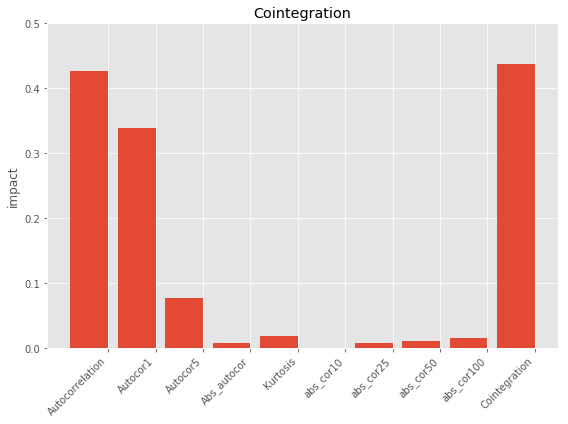

In [81]:
# plot histograms 
#fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,5))
# hist. rects1 = all regressions only 

fig, ax1 = plt.subplots(1, 1, figsize=(8,6))

N = len(direct_effects)
ind = np.arange(N)  # the x locations for the groups
width = 0.8#0.40       # the width of the bars

ax1.set_title('Cointegration')
rects1 = ax1.bar(ind, [x[1] for x in direct_effects], width, label='direct')
#rects2 = ax1.bar(ind + width, [x[1] for x in indirect_effects], width, hatch='\\', label='indirect')
#ax1.legend((rects1[0], rects2[0]), ('S1', 'ST'))
ax1.set_ylabel('impact')

ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(test_labels, rotation = 45, ha="right")
ax1.set_ylim(0, 0.5)

#ax1.legend(loc='best')
fig.tight_layout()

fig.savefig('eFast.png')

### Partial (rank) correlation analyses: 

Pearson if relationship is linear
Spearman if relationship is non-linear but monotonic

In [55]:
cors = sc_fast2.loc[:, sc_fast2.columns != 'mcr_scores']
cors['share_mr'] = pd.Series([x['share_mr'] for x in all_parameters])

In [56]:
cors.corr(method='pearson')['share_mr']

j_score           -0.130396
Autocorrelation    0.134703
Autocor1           0.190409
Autocor5          -0.014652
Abs_autocor        0.007243
Kurtosis           0.080698
abs_cor10               NaN
abs_cor25          0.017482
abs_cor50          0.003174
abs_cor100         0.003329
Cointegration      0.141632
share_mr           1.000000
Name: share_mr, dtype: float64

In [57]:
cors.corr(method='spearman')['share_mr']

j_score           -0.201386
Autocorrelation    0.134995
Autocor1           0.190443
Autocor5          -0.014681
Abs_autocor        0.007256
Kurtosis           0.080726
abs_cor10               NaN
abs_cor25          0.017433
abs_cor50          0.003089
abs_cor100         0.003303
Cointegration      0.141942
share_mr           1.000000
Name: share_mr, dtype: float64